In [1]:
import pandas as pd
import numbers
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from sklearn import tree
import pydot

In [2]:
data = [
    ['<21', 'High', 'Male', 'Single', 'No'],
    ['<21', 'High', 'Male', 'Married', 'No'],
    ['21-35', 'High', 'Male', 'Single', 'Yes'],
    ['>35', 'Medium', 'Male', 'Single', 'Yes'],
    ['>35', 'Low', 'Female', 'Single', 'Yes'],
    ['>35', 'Low', 'Female', 'Married', 'No'],
    ['21-35', 'Low', 'Female', 'Married', 'Yes'],
    ['<21', 'Medium', 'Male', 'Single', 'No'],
    ['<21', 'Low', 'Female', 'Married', 'Yes'],
    ['>35', 'Medium', 'Female', 'Single', 'Yes'],
    ['<21', 'Medium', 'Female', 'Married', 'Yes'],
    ['21-35', 'Medium', 'Male', 'Married', 'Yes'],
    ['21-35', 'High', 'Female', 'Single', 'Yes'],
    ['>35', 'Medium', 'Male', 'Married', 'No']
]

In [3]:
columns = ['Age', 'Income', 'Gender', 'Marital Status', 'Label']

In [4]:
data = pd.DataFrame(data, columns = columns)

In [5]:
data.head()

,Age,Income,Gender,Marital Status,Label
0,<21,High,Male,Single,No
1,<21,High,Male,Married,No
2,21-35,High,Male,Single,Yes
3,>35,Medium,Male,Single,Yes
4,>35,Low,Female,Single,Yes


In [6]:
class Question:
    
    def __init__(self, column, value):
        self.column = column
        self.value = value
    
    def match(self, record):
        record_value = record[self.column]
        
        if(isinstance(record_value, numbers.Number)):
            return record_value >= self.value
        else:
            return record_value == self.value
        
    def __str__(self):
        str = '=='
        if isinstance(self.value, numbers.Number):
            str = '>='
        return 'Condition ->  {} {} {}'.format(columns[self.column], str, self.value)

In [7]:
def divide_rows(rows, question):
    true_rows = []
    false_rows = []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return pd.DataFrame(true_rows, columns = columns), pd.DataFrame(false_rows, columns = columns)


In [8]:
def calculate_gini_impurity(rows):
    counts = rows['Label'].value_counts()
    impurity = 1
    for cnt in counts:
        prob_of_cnt = cnt/float(rows.shape[0])
        impurity -= prob_of_cnt**2
    return impurity

In [9]:
def information_gain(left, right, current_uncertainty):
    p = float(left.shape[0]) / ( float(left.shape[0]) + float(right.shape[0]) )
    return current_uncertainty - p * calculate_gini_impurity(left) - (1-p) * calculate_gini_impurity(right)

In [10]:
def find_best_split(data):
    best_info_gain = 0
    best_question = None
    current_uncertainty = calculate_gini_impurity(data)
    number_of_features = data.shape[1] - 1
    
    for col in range(number_of_features):
        values = data[columns[col]].unique()
        for val in values:
            question = Question(col, val)
            
            true_rows, false_rows = divide_rows(data.values.tolist(), question)
            if true_rows.shape[0] == 0 or false_rows.shape[0] == 0:
                continue
            gain = information_gain(true_rows, false_rows, current_uncertainty)
            #print("\n{},  Gain:{}".format(question, gain))
            if(gain > best_info_gain):
                best_info_gain, best_question = gain, question
    return best_info_gain, best_question

In [11]:
class Leaf:
    def __init__(self, data):
        self.data = data
        yes = data['Label'].value_counts()['Yes'] if 'Yes' in data['Label'].value_counts() else 0
        no = data['Label'].value_counts()['No'] if 'No' in data['Label'].value_counts() else 0
        label = "Yes" if yes > no else "No"
        prob = (yes*100)/(yes+no) if yes>no else (no*100)/(yes+no)
        self.predictions = {label: str(prob)+"%"}
        
    def __str__(self):
        return str(self.data)

In [12]:
class Decision:
    def __init__(self, question, gain, true, false):
        self.question = question
        self.gain = gain
        self.true = true
        self.false = false
        
    def __str__(self):
        return str(self.question) + ", Gain = " + str(round(self.gain, 2))

In [13]:
def build_tree(data):
    gain, question = find_best_split(data)
    if(gain == 0):
        return Leaf(data)

    true_rows, false_rows = divide_rows(data.values.tolist(), question)
    true_branch = build_tree(true_rows)
    false_branch = build_tree(false_rows)
    
    return Decision(question, gain, true_branch, false_branch)


In [14]:
my_tree = build_tree(data)

In [15]:
def classify(row, node):
    if isinstance(node, Leaf):
        return node.predictions
    if node.question.match(row):
        return classify(row, node.true)
    return classify(row, node.false)

In [16]:
pred = classify(data.iloc[1], my_tree)
pred

{'No': '100.0%'}

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [18]:
le = LabelEncoder()
for i in range(5):
    data[columns[i]] = le.fit_transform(data[columns[i]])
data.head()

,Age,Income,Gender,Marital Status,Label
0,1,0,1,1,0
1,1,0,1,0,0
2,0,0,1,1,1
3,2,2,1,1,1
4,2,1,0,1,1


In [19]:
y = data.iloc[:, 4:5]
x = data.iloc[:, 0:4]

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1)

In [22]:
model = DecisionTreeClassifier()
model = model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [23]:
accuracy_score(y_test, y_pred)

0.6666666666666666

[Text(167.4, 195.696, 'X[0] <= 0.5\ngini = 0.463\nsamples = 11\nvalue = [4, 7]'),
 Text(111.60000000000001, 152.208, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(223.20000000000002, 152.208, 'X[2] <= 0.5\ngini = 0.5\nsamples = 8\nvalue = [4, 4]'),
 Text(167.4, 108.72, 'X[3] <= 0.5\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(111.60000000000001, 65.232, 'X[0] <= 1.5\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(55.800000000000004, 21.744, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(167.4, 21.744, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(223.20000000000002, 65.232, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(279.0, 108.72, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]')]

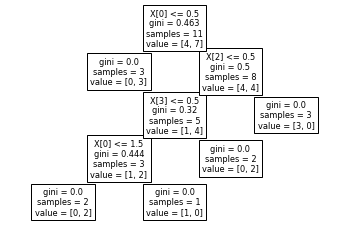

In [24]:
tree.plot_tree(model)